In [1]:
import numpy as np
import pandas as pd
from pandas import datetime, Series

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [50]:
# !curl 'https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv' \
# --output 'data/peyton.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86845  100 86845    0     0   823k      0 --:--:-- --:--:-- --:--:--  823k


In [8]:
df = pd.read_csv('data/peyton.csv',parse_dates=['ds'])
df.ds.min()
df.ds.max()


Timestamp('2007-12-10 00:00:00')

Timestamp('2016-01-20 00:00:00')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nathan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


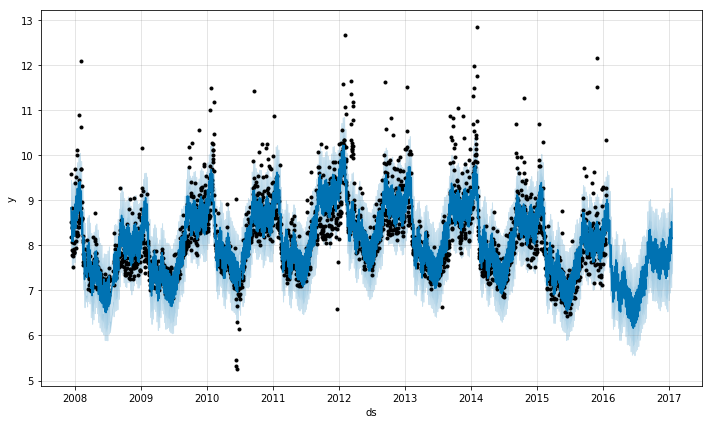

In [3]:
from fbprophet import Prophet

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [4]:
from fbprophet.diagnostics import cross_validation

# horizon represents the window of days that will be forecasted.  below will test 
# windows of 365 days in width.  

# process works from the end.  1st cutoff is max(ds) - horizon
# 2nd cutoff is the first cutoff less period of 180 days.  2nd cutoff will then overlap the
# prior cutoff.

# cutoffs will keep occuring until it reaches and stops before the initial training set, which
# is 730 days wide
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00
/home/nathan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.957184,8.454803,9.469254,8.242493,2010-02-15
1,2010-02-17,8.723619,8.183849,9.205162,8.008033,2010-02-15
2,2010-02-18,8.607378,8.114028,9.097074,8.045268,2010-02-15
3,2010-02-19,8.529250,7.995612,9.023568,7.928766,2010-02-15
4,2010-02-20,8.271228,7.779134,8.746485,7.745003,2010-02-15


In [14]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
3983,2016-01-16,8.592533,7.904446,9.289034,7.817223,2015-01-20
3984,2016-01-17,8.987133,8.238528,9.775135,9.273878,2015-01-20
3985,2016-01-18,9.293324,8.596158,10.013011,10.333775,2015-01-20
3986,2016-01-19,9.076513,8.395909,9.848303,9.125871,2015-01-20
3987,2016-01-20,8.912775,8.184711,9.559848,8.891374,2015-01-20


In [16]:
df_cv.cutoff.unique()

array(['2010-02-15T00:00:00.000000000', '2010-08-14T00:00:00.000000000',
       '2011-02-10T00:00:00.000000000', '2011-08-09T00:00:00.000000000',
       '2012-02-05T00:00:00.000000000', '2012-08-03T00:00:00.000000000',
       '2013-01-30T00:00:00.000000000', '2013-07-29T00:00:00.000000000',
       '2014-01-25T00:00:00.000000000', '2014-07-24T00:00:00.000000000',
       '2015-01-20T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
td = df_cv.cutoff.unique()[-1] - df_cv.cutoff.unique()[-2]
td.astype('timedelta64[D]')

# import datetime
# datetime.date(2015,1,20) - datetime.date(2007, 12, 10)
# datetime.date(2010,2,15) - datetime.date(2015,1,20)

numpy.timedelta64(180,'D')

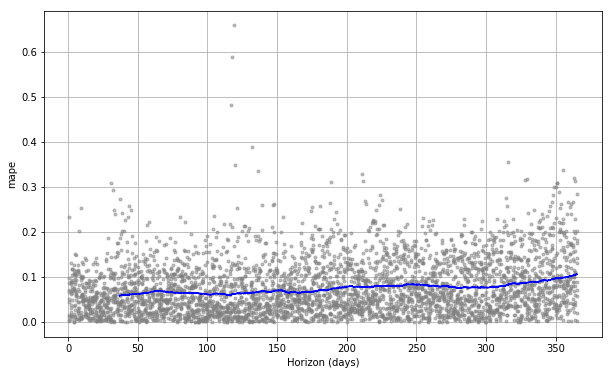

In [15]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
#our mean abs percent error reaches .1 around 350 days